# **CIS 5450 Final Project: Spotify Genre Classification**
*Pedram Bayat, Leha Choppara, Amy Luo, Karishma Gupta*

## Introduction

For this project, our goal was to explore the musical attributes that influence how a song is classified into a particular genre. Leveraging track-level data from Kaggle datasets `spotify-tracks-dataset` and `30000-spotify-songs`,  we built a multi-class classification model to predict genre labels based solely on these audio characteristics. Our goal was not only to achieve strong predictive performance, but also to gain insight into which features are most important for distinguishing between genres like EDM, Pop, Rap, and others.

To do this, we implemented and evaluated several machine learning models, including Random Forest and XGBoost, comparing their performance using classification metrics like precision, recall, and F1 score. We also used statistical hypothesis testing to evaluate patterns we observed in the data—for example, whether high-energy tracks are more likely to be EDM, or whether Rap songs consistently exhibit higher speechiness.

Throughout the notebook, we annotate our models and visualizations with reflections on our choices, key takeaways, and interpretations of the results. By combining predictive modeling with data exploration and statistical analysis, we aim to better understand the subtle relationships between how music sounds and how it's categorized.

## Part 1: Loading Dataset & Preprocessing

Here, we import the  libraries for data manipulation, visualization, machine learning models, and neural networks necessary for the purpose of our classifier. This includes standard Python libraries (pandas, numpy), sklearn for ML models, PyTorch for deep learning experimentation, and seaborn/matplotlib for visualizations.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random
import string
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

##1.1 Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!!kaggle datasets download maharshipandya/-spotify-tracks-dataset

['Dataset URL: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset',
 'License(s): ODbL-1.0',
 '-spotify-tracks-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
songs_df = pd.read_csv('/content/-spotify-tracks-dataset.zip',index_col=0)
songs_df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
# Getting an overview of the data
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

We're only interested in the songs and their audio features, so we'll drop the unnecessary columns, including `artists, album_name, popularity, explicit`. There's also one song that doesn't have a name in this dataset, so we'll consider that row `null` and drop it.


In [ ]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
songs_df = (
    songs_df
    [['track_id', 'track_name', 'track_genre'] + features]
    .dropna()
    .reset_index(drop=True)
)
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113999 entries, 0 to 113998
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113999 non-null  object 
 1   track_name        113999 non-null  object 
 2   track_genre       113999 non-null  object 
 3   danceability      113999 non-null  float64
 4   energy            113999 non-null  float64
 5   key               113999 non-null  int64  
 6   loudness          113999 non-null  float64
 7   mode              113999 non-null  int64  
 8   speechiness       113999 non-null  float64
 9   acousticness      113999 non-null  float64
 10  instrumentalness  113999 non-null  float64
 11  liveness          113999 non-null  float64
 12  valence           113999 non-null  float64
 13  tempo             113999 non-null  float64
dtypes: float64(9), int64(2), object(3)
memory usage: 12.2+ MB


##1.2 Pre-Processing
The dataset contains 114 unique music genres, each containing 1,000 songs. While this makes for a very balanced dataset that could be ideal for modeling, the large number of classes would make our classification overly complex and susceptible to noise. To optimize for accuracy and interpretability, we map each the 114 genres into broader categories. We also remove some of the genres that less traditional (e.g. "sleep", "study", "children").

In [ ]:
# Displaying the number of unique genres in our dataset
songs_df['track_genre'].nunique()

114

In [ ]:
songs_df.groupby('track_genre').count()['track_id']

,track_id
track_genre,
acoustic,1000
afrobeat,1000
alt-rock,1000
alternative,1000
ambient,1000
...,...
techno,1000
trance,1000
trip-hop,1000


#### 1.2.1 Clustering sub-genres into broader categories to reduce the number of classes

In [ ]:
# Mapping of genres to broader categories.
adjusted_genres = {
    'Hip-Hop/Rap': ['hip-hop'],
    'Pop': ['disney', 'indie-pop', 'pop', 'pop-film', 'k-pop', 'j-pop', 'party', 'mandopop', 'cantopop', 'happy', 'acoustic'],
    'Rock': ['rock', 'death-metal', 'hard-rock', 'metal', 'rock-n-roll', 'alt-rock', 'hardcore', 'metal', 'punk', 'punk-rock','heavy-metal'],
    'EDM': ['dance', 'deep-house', 'disco', 'edm', 'house', 'techno', 'electro', 'dubstep', 'chicago-house', 'detroit-techno', 'garage'],
    'Latin': ['brazil', 'latin', 'salsa', 'samba', 'latino', 'mpb'],
    'R&B': ['funk', 'r-n-b', 'groove', 'soul', 'chill'],
    'Classical': ['classical', 'opera', 'piano', 'ambient', 'sleep', 'study', 'new-age']
}

# Flattening the dictionary for easier mapping
genre_to_class = {}
for genre_class, genres in adjusted_genres.items():
    if isinstance(genres, list):
        for genre in genres:
            genre_to_class[genre] = genre_class
    else:
        genre_to_class[genres] = genre_class



In [ ]:
# Mapping to genre classes
songs_df['genre_class'] = songs_df['track_genre'].map(genre_to_class)

In [ ]:
# Dropping excluded genres (they will have null values in 'genre_class')
songs_df = songs_df.dropna().reset_index(drop=True)

In [ ]:
songs_df.head()

,track_id,track_name,track_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_class
0,5SuOikwiRyPMVoIQDJUgSV,Comedy,acoustic,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,Pop
1,4qPNDBW1i3p13qLCt0Ki3A,Ghost - Acoustic,acoustic,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,Pop
2,1iJBSr7s7jYXzM8EGcbK5b,To Begin Again,acoustic,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,Pop
3,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,acoustic,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,Pop
4,5vjLSffimiIP26QG5WcN2K,Hold On,acoustic,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,Pop


In [ ]:
songs_df.shape

(50999, 15)

In [ ]:
# genres_df = pd.DataFrame(songs_df['track_genre'].unique().tolist())
# genres_df.to_excel('genres.xlsx')

#### 1.2.2 Adding data from other datasets to address class imbalance
We load in `extra_songs_df`, which is a dataset containing songs from six genres that are included in our original dataset. Particularly, we merge the rap, r&b, and latin songs from this dataset into `songs_df`.

We only categorized one genre into the greater Hip-Hop genre class, so we use another Spotify dataset to increase the number of songs under the Hip-Hop category and address class imbalance.

In [ ]:
!!kaggle datasets download 'joebeachcapital/30000-spotify-songs'

['Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs',
 'License(s): DbCL-1.0',
 '30000-spotify-songs.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
!unzip /content/30000-spotify-songs.zip

Archive:  /content/30000-spotify-songs.zip
replace readme.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: readme.md               
replace spotify_songs.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spotify_songs.csv       


In [ ]:
extra_songs_df = pd.read_csv('spotify_songs.csv')
extra_songs_df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [ ]:
extra_songs_df.groupby('playlist_genre').count()['track_id']

,track_id
playlist_genre,
edm,6043
latin,5155
pop,5507
r&b,5431
rap,5746
rock,4951


In [ ]:
extra_songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [ ]:
rap_songs = extra_songs_df[extra_songs_df['playlist_genre'] == 'rap']
rap_songs = rap_songs.rename(columns={'playlist_genre': 'track_genre'})
rap_songs = rap_songs[['track_id', 'track_name', 'track_genre'] + features]
rap_songs['genre_class'] = 'Hip-Hop/Rap'
rap_songs = rap_songs[songs_df.columns]
rap_songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5746 entries, 5507 to 11252
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          5746 non-null   object 
 1   track_name        5743 non-null   object 
 2   track_genre       5746 non-null   object 
 3   danceability      5746 non-null   float64
 4   energy            5746 non-null   float64
 5   key               5746 non-null   int64  
 6   loudness          5746 non-null   float64
 7   mode              5746 non-null   int64  
 8   speechiness       5746 non-null   float64
 9   acousticness      5746 non-null   float64
 10  instrumentalness  5746 non-null   float64
 11  liveness          5746 non-null   float64
 12  valence           5746 non-null   float64
 13  tempo             5746 non-null   float64
 14  genre_class       5746 non-null   object 
dtypes: float64(9), int64(2), object(4)
memory usage: 718.2+ KB


In [ ]:
rnb_songs = extra_songs_df[extra_songs_df['playlist_genre'] == 'r&b']
rnb_songs = rnb_songs.rename(columns={'playlist_genre': 'track_genre'})
rnb_songs = rnb_songs[['track_id', 'track_name', 'track_genre'] + features]
rnb_songs['genre_class'] = 'R&B'
rnb_songs = rnb_songs[songs_df.columns]
rnb_songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5431 entries, 21359 to 26789
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          5431 non-null   object 
 1   track_name        5431 non-null   object 
 2   track_genre       5431 non-null   object 
 3   danceability      5431 non-null   float64
 4   energy            5431 non-null   float64
 5   key               5431 non-null   int64  
 6   loudness          5431 non-null   float64
 7   mode              5431 non-null   int64  
 8   speechiness       5431 non-null   float64
 9   acousticness      5431 non-null   float64
 10  instrumentalness  5431 non-null   float64
 11  liveness          5431 non-null   float64
 12  valence           5431 non-null   float64
 13  tempo             5431 non-null   float64
 14  genre_class       5431 non-null   object 
dtypes: float64(9), int64(2), object(4)
memory usage: 678.9+ KB


In [ ]:
latin_songs = extra_songs_df[extra_songs_df['playlist_genre'] == 'latin']
latin_songs = latin_songs.rename(columns={'playlist_genre': 'track_genre'})
latin_songs = latin_songs[['track_id', 'track_name', 'track_genre'] + features]
latin_songs['genre_class'] = 'Latin'
latin_songs = latin_songs[songs_df.columns]
latin_songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5155 entries, 16204 to 21358
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          5155 non-null   object 
 1   track_name        5153 non-null   object 
 2   track_genre       5155 non-null   object 
 3   danceability      5155 non-null   float64
 4   energy            5155 non-null   float64
 5   key               5155 non-null   int64  
 6   loudness          5155 non-null   float64
 7   mode              5155 non-null   int64  
 8   speechiness       5155 non-null   float64
 9   acousticness      5155 non-null   float64
 10  instrumentalness  5155 non-null   float64
 11  liveness          5155 non-null   float64
 12  valence           5155 non-null   float64
 13  tempo             5155 non-null   float64
 14  genre_class       5155 non-null   object 
dtypes: float64(9), int64(2), object(4)
memory usage: 644.4+ KB


In [ ]:
songs_df = pd.concat([songs_df, rap_songs, rnb_songs, latin_songs], ignore_index=True)

In [ ]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67331 entries, 0 to 67330
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          67331 non-null  object 
 1   track_name        67326 non-null  object 
 2   track_genre       67331 non-null  object 
 3   danceability      67331 non-null  float64
 4   energy            67331 non-null  float64
 5   key               67331 non-null  int64  
 6   loudness          67331 non-null  float64
 7   mode              67331 non-null  int64  
 8   speechiness       67331 non-null  float64
 9   acousticness      67331 non-null  float64
 10  instrumentalness  67331 non-null  float64
 11  liveness          67331 non-null  float64
 12  valence           67331 non-null  float64
 13  tempo             67331 non-null  float64
 14  genre_class       67331 non-null  object 
dtypes: float64(9), int64(2), object(4)
memory usage: 7.7+ MB


Once the join has been completed, we remove the `track_genre` column since it is now unncessary.

In [ ]:
songs_df = songs_df.drop(columns=['track_genre'])

There is still moderate class imabalance among the genres, which we aim to address later with gradient boosting. The main takeaway is that we have reduced the 114 unique genres to a total of 7, with many songs in each genre.

In [ ]:
songs_df.groupby('genre_class').count()['track_id']

,track_id
genre_class,
Classical,7000
EDM,11000
Hip-Hop/Rap,6746
Latin,11155
Pop,10999
R&B,10431
Rock,10000


## Part 2: Exploratory Data Analysis
Now that we have processed our `songs_df`, we can explore the different genres.

EDA allowed us to observe how different features of audio map onto genre. We used violin plots to observe how the distribution of features like energy, speechiness, and acousticness differ between genres. These plots revealed patterns; for example, classical music is less energetic and more acoustic.

We also created a correlation heatmap to see which features were highly correlated, which allowed us to take feature redundancy into account. Lastly, Principal Component Analysis (PCA) was utilized to compress feature space and determine if genres could be graphically distinguished in lower-dimensional space.

In [ ]:
# some statistics on the dataset
songs_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,67331.000000,67331.000000,67331.000000,67331.000000,67331.000000,67331.000000,67331.000000,67331.000000,67331.000000,67331.000000,67331.000000
mean,0.600063,0.637047,5.364008,-8.214177,0.608962,0.090617,0.291157,0.139450,0.200718,0.488353,120.326251
std,0.178403,0.242622,3.590554,5.253871,0.487987,0.091034,0.317152,0.299788,0.176678,0.253270,30.019315
min,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.488000,0.488000,2.000000,-9.624500,0.000000,0.037400,0.023600,0.000000,0.095300,0.284000,96.399000
50%,0.625000,0.677000,6.000000,-6.838000,1.000000,0.052900,0.152000,0.000018,0.127000,0.487000,120.020000
75%,0.734000,0.830000,9.000000,-4.997500,1.000000,0.100000,0.509000,0.016450,0.254000,0.692000,139.078000
max,0.983000,1.000000,11.000000,2.574000,1.000000,0.924000,0.996000,1.000000,1.000000,0.994000,239.440000


#### 2.1 Number of songs per genre

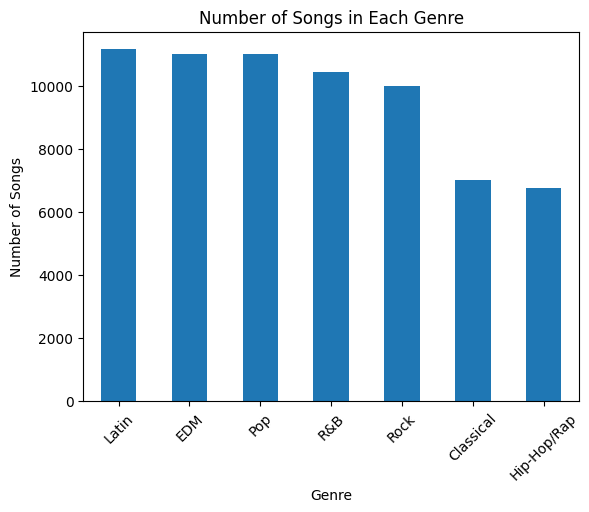

In [ ]:
# how many songs are in each genre
plt.figure()
songs_df['genre_class'].value_counts().plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Number of Songs in Each Genre')
plt.xticks(rotation=45)
plt.show()

**Takeaways:**
Latin, EDM, and Pop ended up having the largest number of songs in the dataset. There is a notable class imbalanace across the genres, with Latin having roughly 60% more songs than Hip-Hop/Rap. This may affect our models, as they could overfit to overrepresented classes, so we later address this with class weighting and SMOTE.

#### 2.2 Distribution of audio features in each genre

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


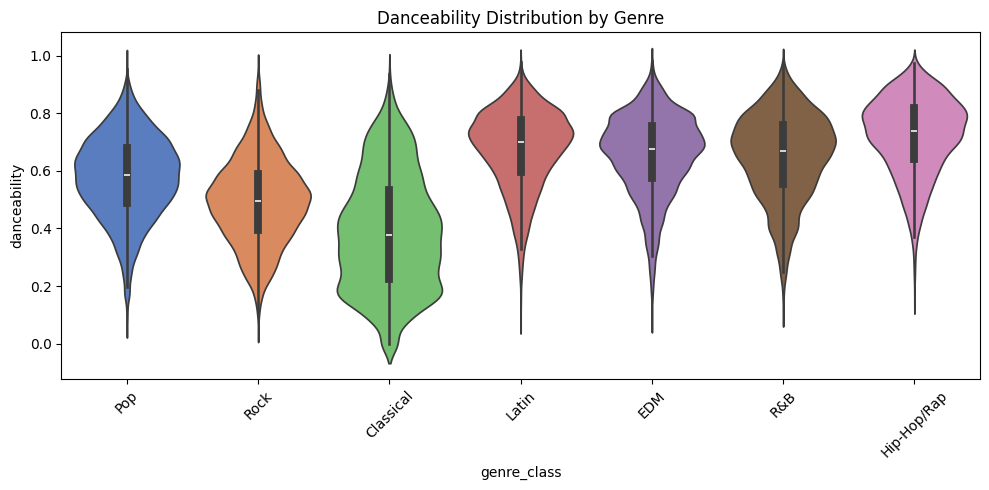

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


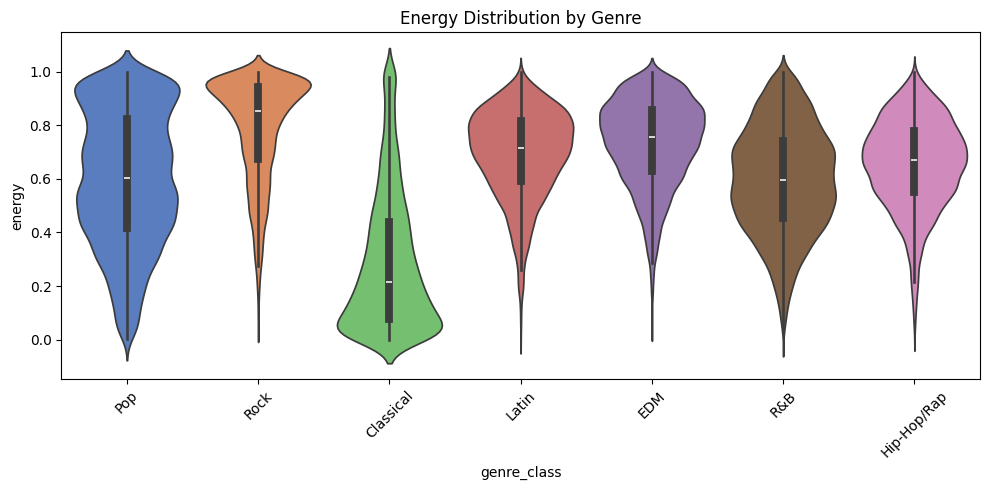

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


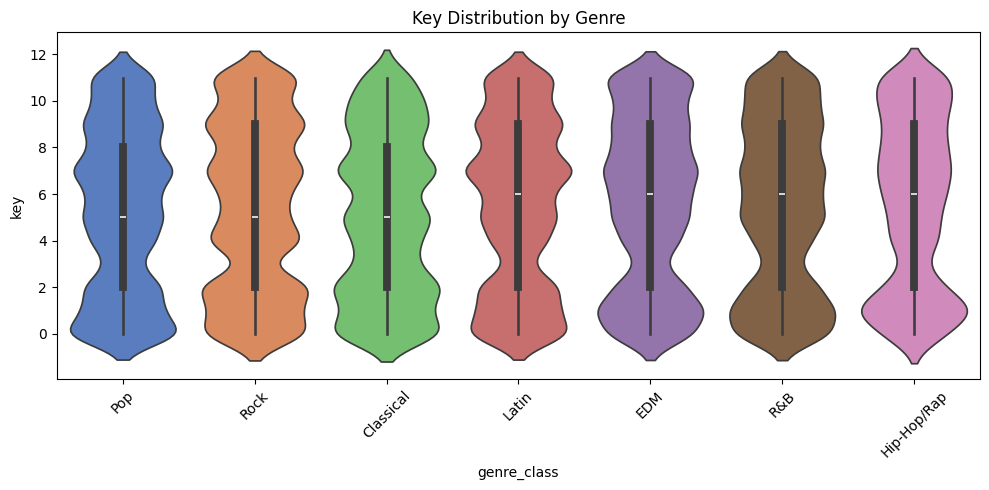

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


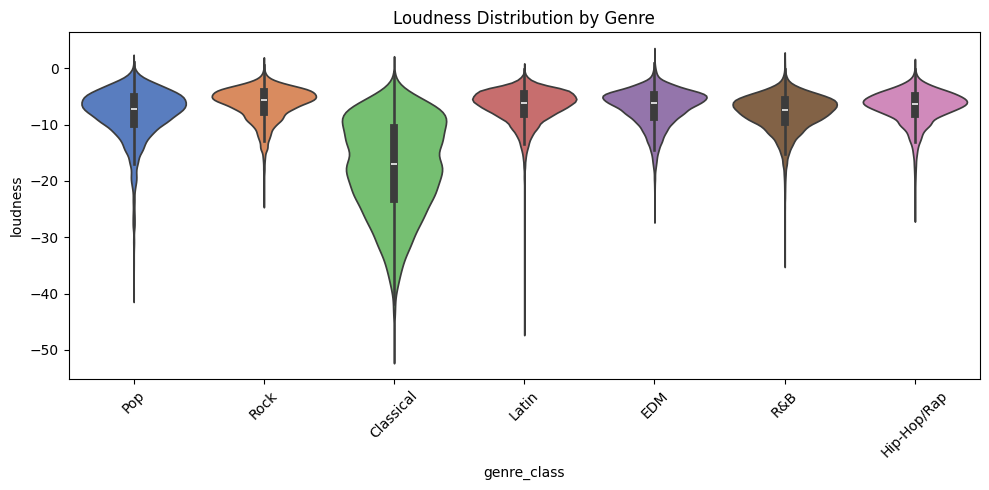

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


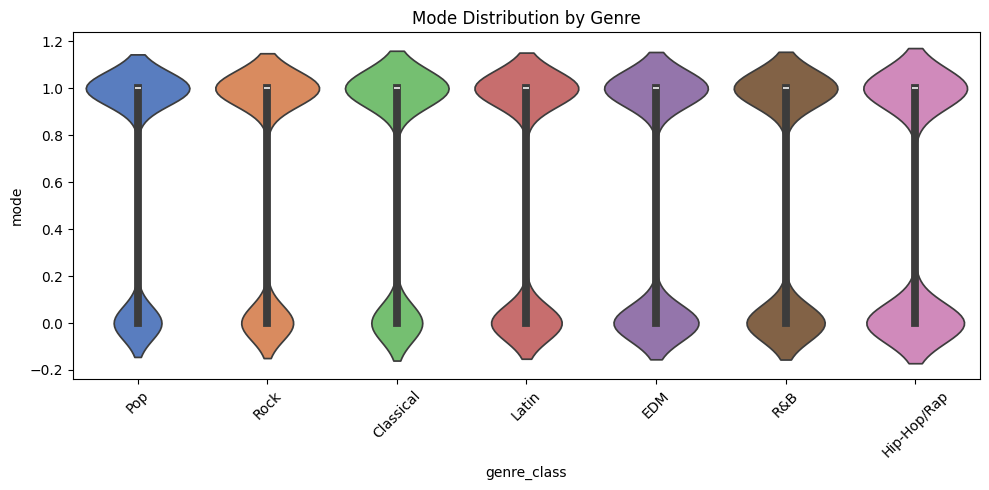

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


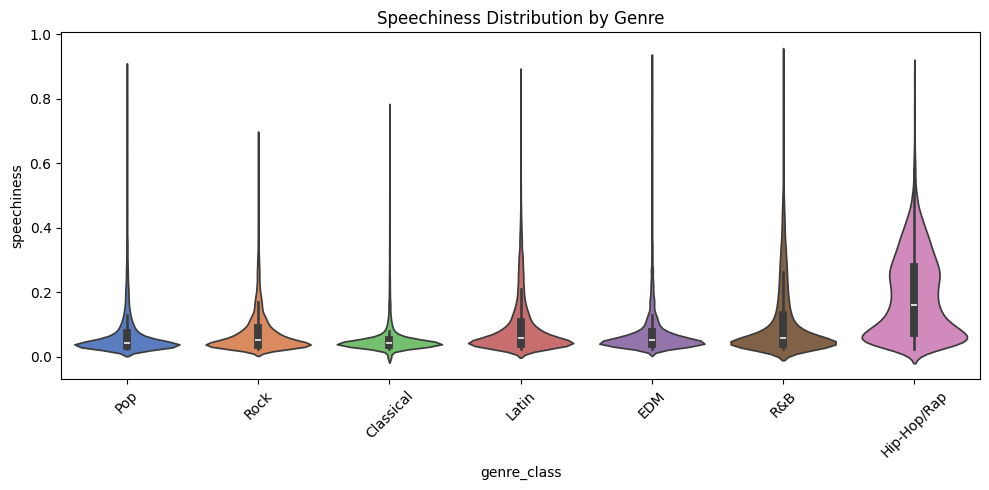

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


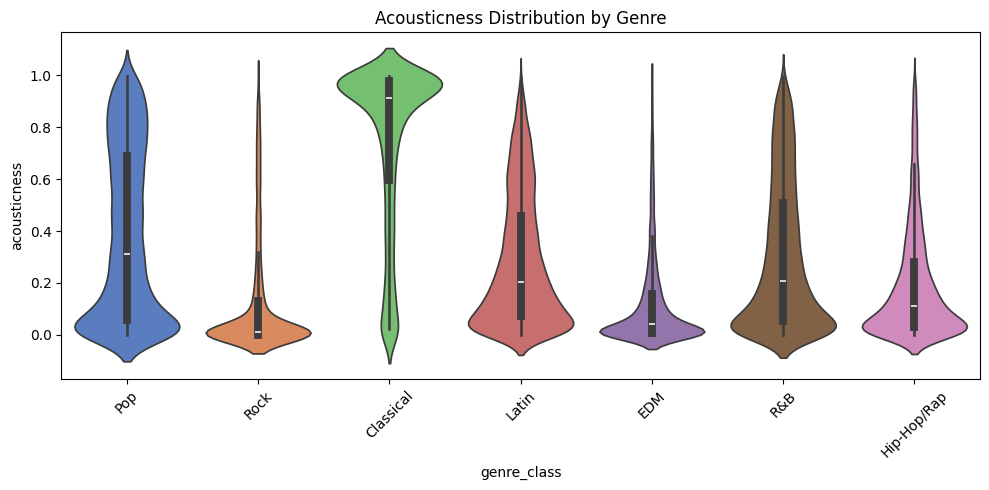

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


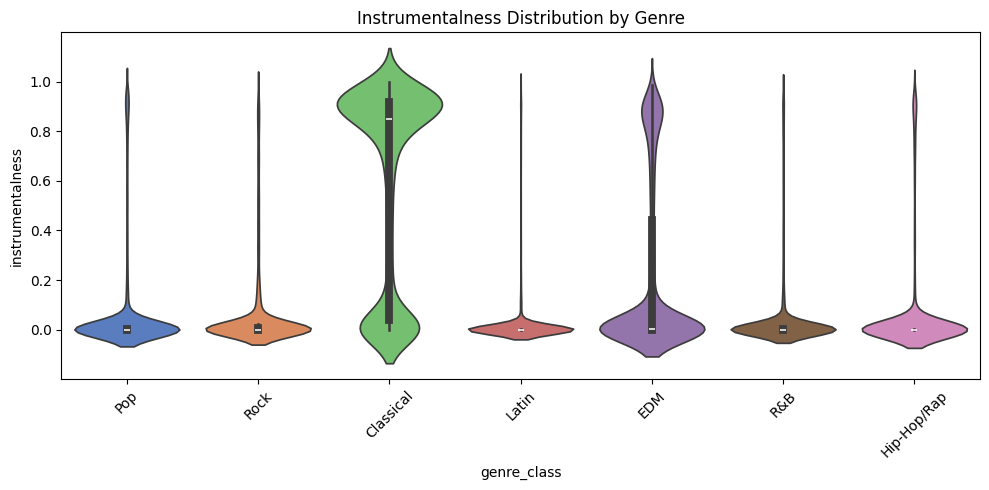

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


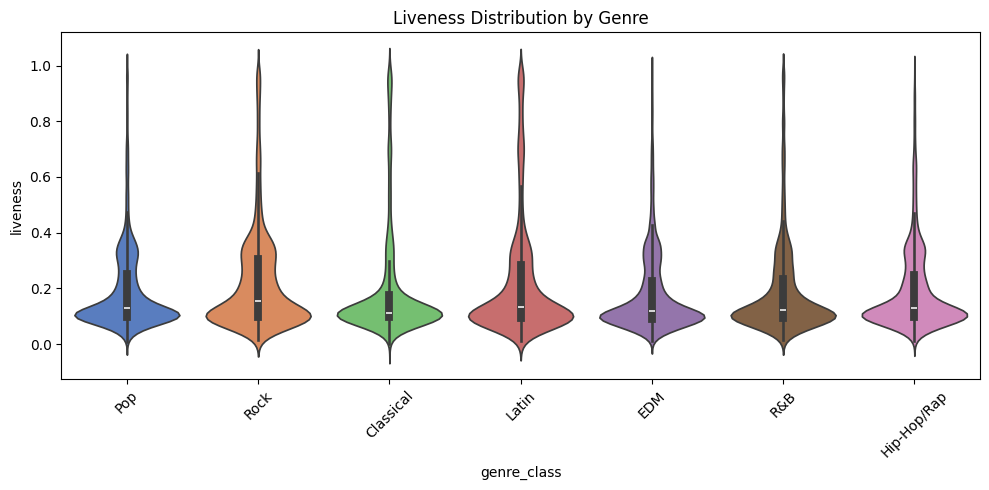

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


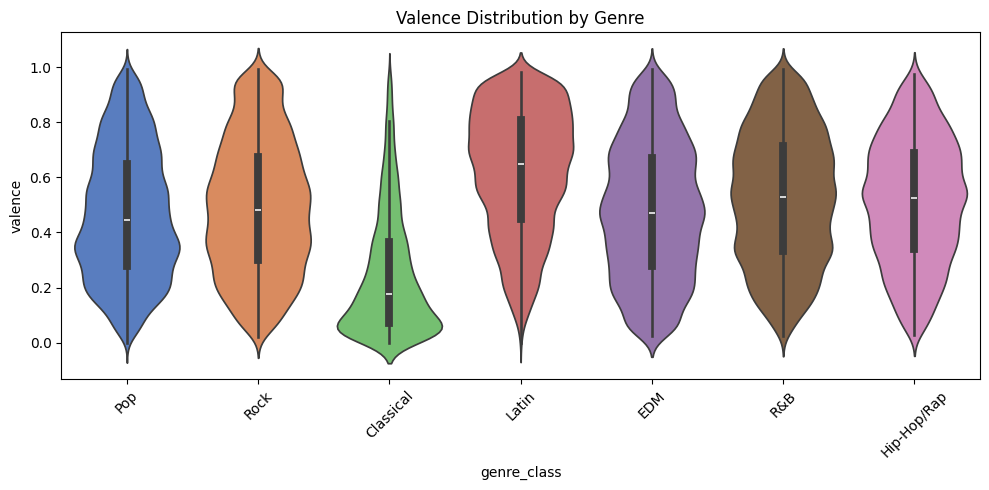

<ipython-input-31-e18836688d79>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')


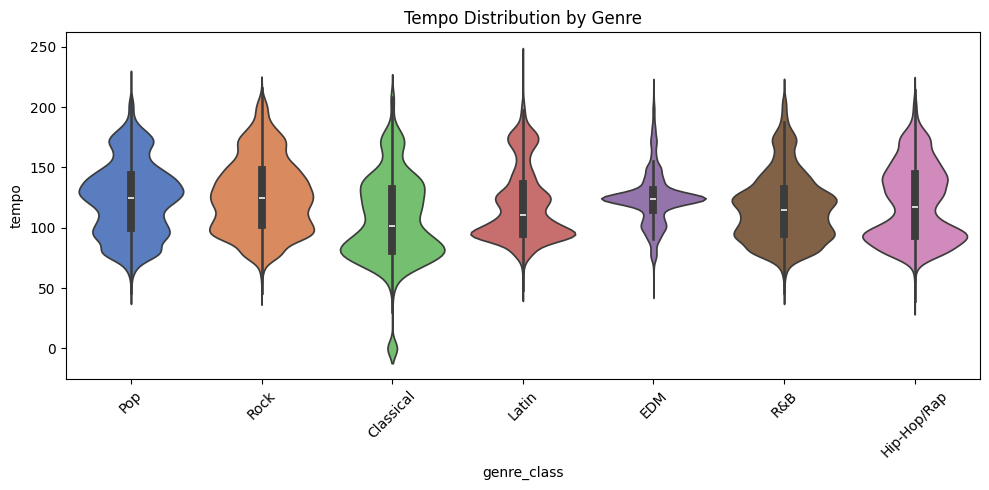

In [ ]:
# These are the audio features we are exploring, defined by spotify. Here we show the distribution of features by each genre.

for col in features:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x='genre_class', y=col, data=songs_df, palette='muted')
    plt.title(f'{col.capitalize()} Distribution by Genre')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Takeaways**: Most genres seem to have similar distributions across the different audio features. Classical had the biggest difference when compared to other genres in features like valence, instrumentalness, acousticness, loudness, and energy. This makes sense, considering classical music sounds very different than the other genres. These results indicate that our models could be

#### 2.3 Correlation matrix between audio features

In [ ]:
# Correlation matrix of audio features
corr_matrix = songs_df[features].corr()
fig = px.imshow(
  corr_matrix,
  color_continuous_scale='RdBu',
  title='Correlation Matrix of Audio Features',
  text_auto='.2f')
fig.show()

**Takeaways**: There are strong positive and negative correlations between some audio features. For example, energy and loudness have a correlation of 0.75, which makes sense considering louder songs are typically more energetic. There is also a high correlation between danceability and valence, which also makes sense because more danceable songs tend to be more positive or happy. Similarly, some features have strong negative correlations which also make intuitive sense. Most genres are not very strongly correlated, however, so there are no strong negative implications for model performance from this correlation matrix.

### 2.4 Radar Plots of Average Audio Features in Each Genre
We compare the average values of features per each genre in a circular radar chart.

In [ ]:
import plotly.graph_objects as go

mean_genres = songs_df.groupby('genre_class')[features].mean()
mean_genres_normalized = (mean_genres - mean_genres.min()) / (mean_genres.max() - mean_genres.min())

for genre in mean_genres_normalized.index:
  genre_data = mean_genres_normalized.loc[genre].values.flatten().tolist()
  genre_data += genre_data[:1]
  labels = features + [features[0]]

  fig = go.Figure()
  fig.add_trace(go.Scatterpolar(
      r=genre_data,
      theta=labels,
      fill='toself',
      name=genre
  ))

  fig.update_layout(
      polar=dict(
          radialaxis=dict(visible=True, range=[0, 1]),
      ),
      title=f'Average Audio Features for {genre}',
      showlegend=True
  )

  fig.show()

**Takeaways:** The radar plots provide an interesting visual insight to the audio features that are most prominent in each genre. For example, classical and EDM seem to be "polar opposites", which makes sense considering how different they are. Besides classical music, the majority of the genres have graphs that look pretty similar, with some small discrepancies. This may indicate that it could be difficult to classify songs into genres with high quality.

### 2.5 Principal Component Analysis & Dimensionality Reduction
 Dimensionality reduction through PCA would combine the audio features into principal components. We can then plot the principal components into clusters and observe how songs in some genres may be grouped differently than songs in other genres. This could indicate if some genres are naturally distinct or similar based solely on audio features.

In [ ]:
from sklearn.decomposition import PCA
X = songs_df[features]
y = songs_df['genre_class']

# scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# perform PCA and store results in a dataframe
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# performing PCA
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['genre_class'] = y.values

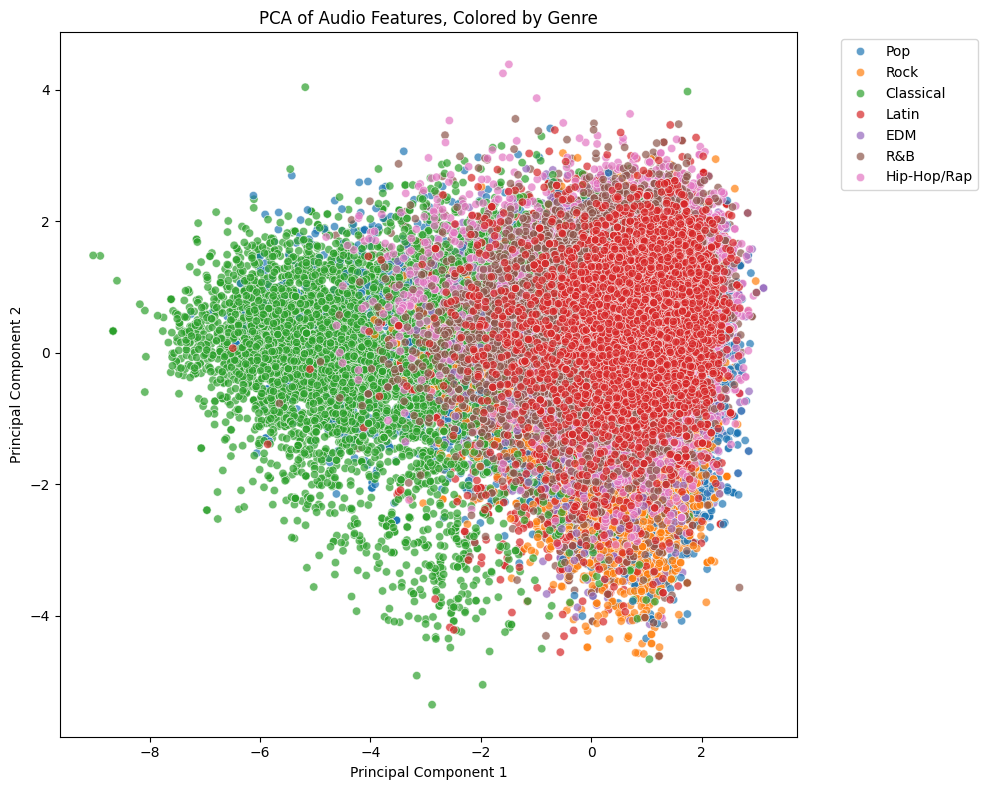

In [ ]:
# plotting results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='genre_class', data=pca_df, palette='tab10', alpha=0.7)
plt.title('PCA of Audio Features, Colored by Genre')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# some more PCA results
print(f'Explained variance by PC1: {pca.explained_variance_ratio_[0]:.2%}')
print(f'Explained variance by PC2: {pca.explained_variance_ratio_[1]:.2%}')
print(f'Total variance explained by PC1 and PC2: {sum(pca.explained_variance_ratio_[:2]):.2%}')

Explained variance by PC1: 28.95%
Explained variance by PC2: 11.81%
Total variance explained by PC1 and PC2: 40.76%


In [ ]:
# Get the feature loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2'],
                        index=features)

print("Top features contributing to PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False))

print("\nTop features contributing to PC2:")
print(loadings['PC2'].abs().sort_values(ascending=False))


Top features contributing to PC1:
loudness            0.486207
energy              0.468481
acousticness        0.426712
instrumentalness    0.335249
valence             0.319820
danceability        0.298898
speechiness         0.159756
tempo               0.147369
mode                0.074150
key                 0.051798
liveness            0.051057
Name: PC1, dtype: float64

Top features contributing to PC2:
danceability        0.557453
liveness            0.449390
valence             0.336100
tempo               0.325233
energy              0.271427
mode                0.269095
key                 0.193889
speechiness         0.193239
acousticness        0.177216
loudness            0.126998
instrumentalness    0.001250
Name: PC2, dtype: float64


**Takeaways from PCA**: The clusters overlap, and the genres are not linearly separable. There are some trends with classical leaning left and other genres leaning right, but there is still substantial overlap. It is important to note that the PCA will only capture linear combinations of features, so it explains variations in the genres but can miss nonlinear patterns.

In [ ]:
from sklearn.manifold import TSNE
# X_tsne_input = X_scaled
# y_tsne_input = y

# run t-SNE
sample_size = 20000
sample_idx = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)
X_tsne_input = X_scaled[sample_idx]
y_tsne_input = y.iloc[sample_idx]

# tsne = TSNE(n_components=2
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_input)

tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE1', 't-SNE2'])
tsne_df['genre_class'] = y_tsne_input

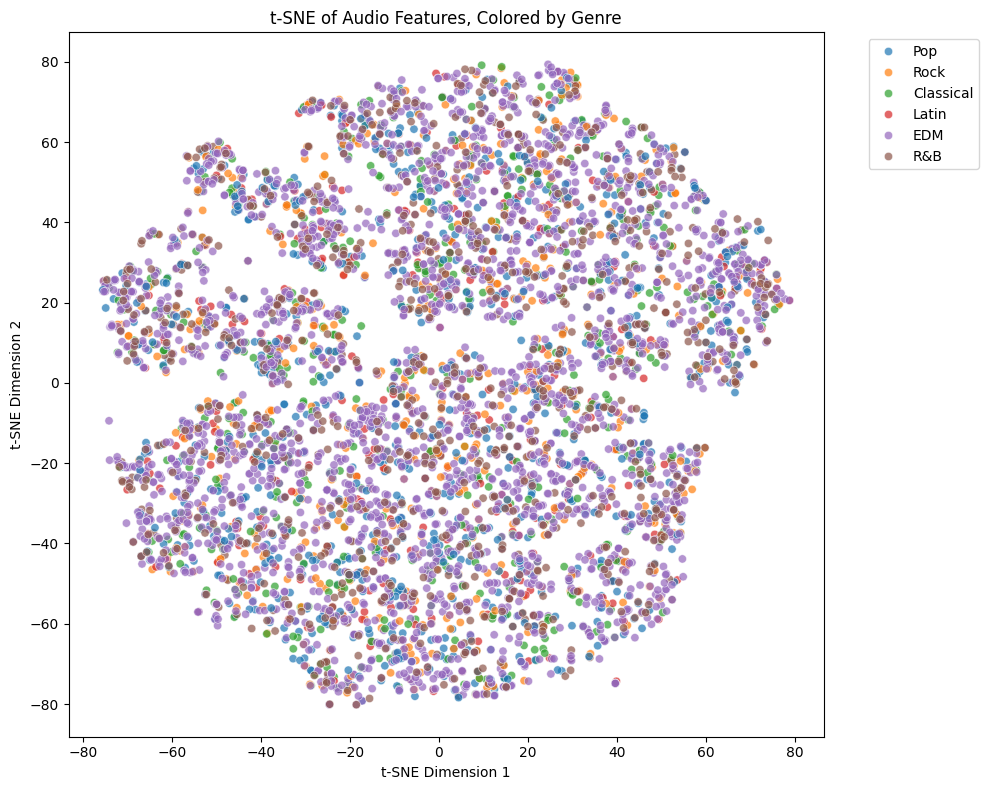

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='genre_class', data=tsne_df, palette='tab10', alpha=0.7)
plt.title('t-SNE of Audio Features, Colored by Genre')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Takeaways from t-SNE**: The t-SNE dimensionality reduction better identified local clusters, but the genres are still heavily mixed together. The entire plot seems to be saturated with EDM songs, which could be because of the class imbalance or that the t-SNE focused more on EDM.

## Part 3. Modeling

We began using logistic regression to establish a baseline. It is an interpretable and simple model but it assumes linear separability between classes, which something that isn't always the case for musical genres. The model performed moderately, and this illustrated the need for more advanced models.

We experimented with the model using not just accuracy, but precision, recall, and F1-score to test how well the model handled imbalanced classes as well as genre confusion.

### 3.1 Feature Engineering

#### 3.1.1 LabelEncoder to encode genres as numbers

In [ ]:
# Encode genre to numbers
label_encoder = LabelEncoder()
songs_df['genre_class_encoded'] = label_encoder.fit_transform(songs_df['genre_class'])

#### 3.1.2 Train-Test Split
We apply a standard train-test split, using the stratify parameter to preserve class distributions between the training and test sets.

In [ ]:
# Features and target
X = songs_df[features]
y = songs_df['genre_class_encoded']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.1.2.1 Baseline Model Evaluation

Before we address class imbalance in our dataset, we evaluate a baseline model using a Random Forest Classifier to provide a benchmark.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the Random Forest Classifier
baseline_model = RandomForestClassifier(random_state=42)

# Train the model on training data
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred_baseline, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   Classical       0.77      0.82      0.79      1413
         EDM       0.63      0.65      0.64      2148
 Hip-Hop/Rap       0.51      0.52      0.51      1293
       Latin       0.57      0.56      0.56      2194
         Pop       0.54      0.55      0.55      2193
         R&B       0.51      0.42      0.46      2175
        Rock       0.67      0.73      0.70      2051

    accuracy                           0.60     13467
   macro avg       0.60      0.61      0.60     13467
weighted avg       0.59      0.60      0.60     13467



The baseline Random Forest Classifier's varied precision and recall across genres, particularly lower performance on Hip-Hop/Rap and R&B, suggests class imbalance. We hypothesize this disparity stems from an uneven distribution of genres in the training set, motivating the use of SMOTE to balance classes.

#### 3.1.3 SMOTE to address class imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

Before SMOTE: genre_class_encoded
3    8961
1    8852
4    8806
5    8256
6    7949
0    5587
2    5453
Name: count, dtype: int64
After SMOTE: genre_class_encoded
4    8961
0    8961
6    8961
1    8961
5    8961
3    8961
2    8961
Name: count, dtype: int64


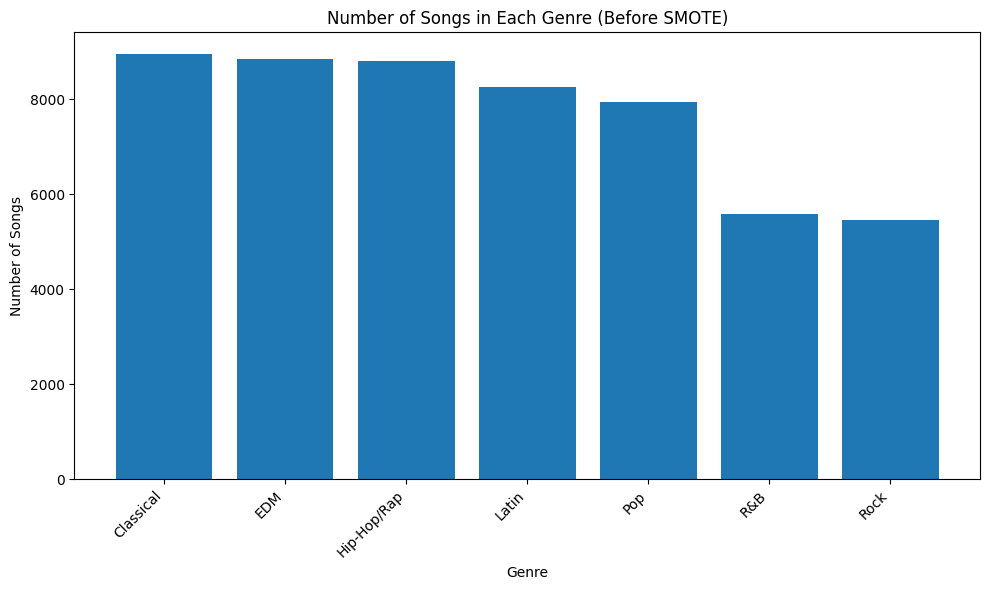

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(label_encoder.classes_, pd.Series(y_train).value_counts())  # Use y_train for original distribution
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Number of Songs in Each Genre (Before SMOTE)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

Text(0.5, 1.0, 'Number of Songs in Each Genre (After SMOTE)')

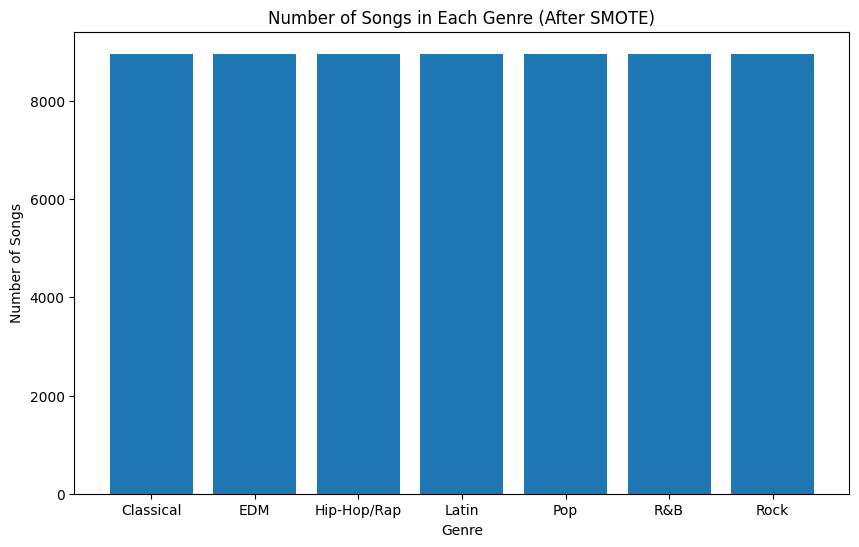

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(label_encoder.classes_, pd.Series(y_train_resampled).value_counts())
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Number of Songs in Each Genre (After SMOTE)')

### 3.2 Model Evaluation
Following feature engineering, we now examine different classifier models and determine their performance.


#### 3.2.1 Random Forest Classifier

In [ ]:
# hyperparameter tuning
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
  )

param_grid = {
    'n_estimators': [100, 200, 300,],
    'max_depth': [None, 10, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=3,
    scoring='f1_weighted',
    cv=4,
    verbose=3,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

search.fit(X_train, y_train)

best_rf = search.best_estimator_
ideal_params = search.best_params_

print("Best model:", best_rf)
print("Ideal parameters:", ideal_params)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
Best model: RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=25,
                       max_features='log2', min_samples_split=5,
                       random_state=42)
Ideal parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 25, 'class_weight': 'balanced', 'bootstrap': False}


In [ ]:
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   Classical       0.76      0.83      0.79      1413
         EDM       0.64      0.64      0.64      2148
 Hip-Hop/Rap       0.49      0.55      0.52      1293
       Latin       0.57      0.54      0.55      2194
         Pop       0.54      0.55      0.54      2193
         R&B       0.50      0.42      0.45      2175
        Rock       0.68      0.73      0.71      2051

    accuracy                           0.60     13467
   macro avg       0.60      0.61      0.60     13467
weighted avg       0.59      0.60      0.59     13467



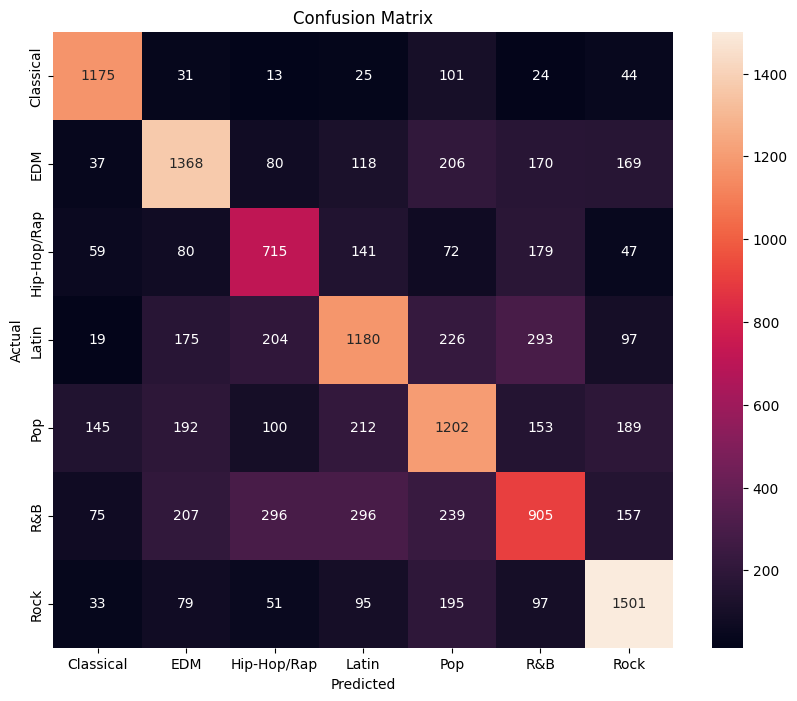

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

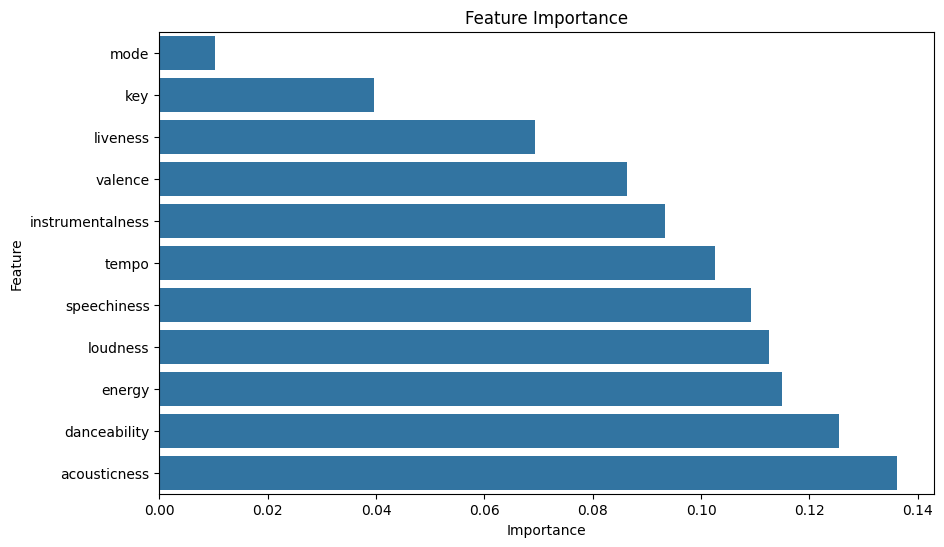

In [ ]:
# feature importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(features)[indices], orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### 3.2.2 XGBoost
As mentioned earlier, our genre classes have a moderate class imbalance. So, we will implement XGBoost. We compute weights inversely proportional to class frequencies, which provides higher weight to genres with lower frequency, effectively boosting their contribution to the loss function.

In [ ]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

First, we compute the sample weights only for the training set (to prevent leakage).

In [ ]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

Now, we define the XGBoost classifier.

In [ ]:
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

##### 3.2.2.1 Hyperparameter Tuning

First, we'll define which parameters we are tuning.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_lambda': [1, 10],
    'reg_alpha': [0, 1]
}

Next, implement hyperparameter tuning with RandomizedSearchCV. The data is split with StratifiedKFold into 3.

In [ ]:
splits = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=5,
    scoring='f1_weighted',
    cv=splits,
    verbose=3,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

search.fit(X_train, y_train, sample_weight=sample_weights)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:14:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           im...
                                           n_estimators=None, n_jobs=None,
                                           num_class=7, num_parallel_tree=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'gamma': [0, 1],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [1, 10],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=3)

After the search, we find the best model and the ideal parameters before evaluating it.

In [ ]:
best_model = search.best_estimator_
ideal_params = search.best_params_

print("Best model:", best_model)
print("Ideal parameters:", ideal_params)

Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)
Ideal parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 1.0}


In [ ]:
y_pred_xgb = best_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))
r2_train_xgb = r2_score(y_train, best_model.predict(X_train))
r2_test_xgb = r2_score(y_test, best_model.predict(X_test))
mse = mean_squared_error(y_test, best_model.predict(X_test))

print('Test Set R^2: ' + str(r2_test_xgb))
print('Train Set R^2: ' + str(r2_train_xgb))
print('MSE: ' + str(mse))

              precision    recall  f1-score   support

   Classical       0.75      0.81      0.78      1413
         EDM       0.60      0.62      0.61      2148
 Hip-Hop/Rap       0.45      0.62      0.52      1293
       Latin       0.58      0.51      0.54      2194
         Pop       0.51      0.49      0.50      2193
         R&B       0.49      0.38      0.43      2175
        Rock       0.64      0.70      0.67      2051

    accuracy                           0.57     13467
   macro avg       0.58      0.59      0.58     13467
weighted avg       0.57      0.57      0.57     13467

Test Set R^2: 0.14471661187268647
Train Set R^2: 0.48487523867952165
MSE: 3.2607856241182147


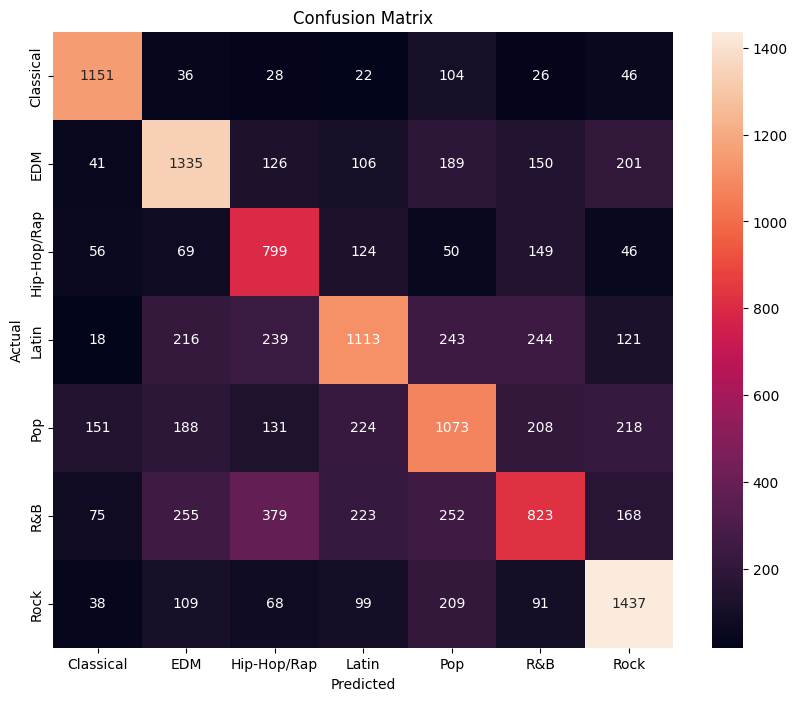

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 3.3 Neural Network Classifier (using Pytorch)

We built a deep neural network with PyTorch with 6+ layers and dropout regularization. This allowed the model to learn complex, non-linear interactions among audio features.
The model was trained with GPU acceleration when it was available and used the Adam optimizer to fine-tune. Dropout layers were added to prevent overfitting through randomly disabling neurons during training (helps to get rid of noise).
We then tested the model after training with a classification report and confusion matrix. The model performed better in genres like classical and rock, but there was still some confusion between genres like EDM and pop which are more similar to each other.


#### 3.3.1 Data Prep
Convert data to PyTorch tensors and send them to GPU if its available. Also prepare DataLoaders for training in batches.

In [ ]:
#Sending to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Creating tensors from the test data and the training data
X_train_tensor = torch.from_numpy(X_train.values).float().to(device)
y_train_tensor = torch.from_numpy(y_train.values).long().to(device)
X_test_tensor = torch.from_numpy(X_test.values).float().to(device)
y_test_tensor = torch.from_numpy(y_test.values).long().to(device)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
#Verifying the number of features & rows within tensors
print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)

torch.Size([53864, 11]) torch.Size([13467, 11]) torch.Size([53864]) torch.Size([13467])


#### 3.3.2 Defining Neural Network Architecture

In [ ]:
class GenreClassifier(nn.Module):
  def __init__(self, input_dim, num_classes):
    super(GenreClassifier, self).__init__()
    self.fc1 = nn.Linear(input_dim, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 32)
    self.fc6 = nn.Linear(32, 16)
    self.output = nn.Linear(16, num_classes)
    self.dropout = nn.Dropout(0.3)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.relu(self.fc3(x))
    x = self.dropout(x)
    x = self.relu(self.fc4(x))
    x = self.relu(self.fc5(x))
    x = self.relu(self.fc6(x))
    x = self.output(x)
    return x

In [ ]:
input_dim = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = GenreClassifier(input_dim, num_classes).to(device)

#### 3.3.3 Loss Function & Optimizer

In [ ]:
lossFunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

#### 3.3.4 Training the Neural Network

In [ ]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  for batch_X, batch_y in train_loader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = lossFunc(outputs, batch_y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader)
  train_losses.append(epoch_loss)

In [ ]:
#evaluating the nueral network as a model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
  for batch_X, batch_y in test_loader:
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)
    outputs = model(batch_X)
    _, predicted = torch.max(outputs, 1)
    y_pred.extend(predicted.cpu().numpy().tolist())
    y_true.extend(batch_y.cpu().numpy().tolist())

print("\nNeural Network Performance:")
print(classification_report(y_true, y_pred, target_names = label_encoder.classes_))


Neural Network Performance:
              precision    recall  f1-score   support

   Classical       0.76      0.77      0.76      1413
         EDM       0.52      0.49      0.50      2148
 Hip-Hop/Rap       0.43      0.51      0.46      1293
       Latin       0.49      0.44      0.47      2194
         Pop       0.39      0.43      0.41      2193
         R&B       0.37      0.26      0.31      2175
        Rock       0.53      0.67      0.59      2051

    accuracy                           0.49     13467
   macro avg       0.50      0.51      0.50     13467
weighted avg       0.49      0.49      0.49     13467



## Part 4. Hypothesis Testing

### 4.1 Introduction

Following model evaluation, we want to validate specific patterns observed in the data and assess the validity of claims about our models' behavior through hypothesis testing.


####4.1.1 Testing Baseline RF Model vs. SMOTE-adjusted RF Model

First, we want to determine if applying SMOTE to address class imbalance leads to a statistically significant improvement in the performance of the Random Forest classifier.

H0: There is no difference in performance between the baseline Random Forest model and the SMOTE-adjusted Random Forest model.

H1: There is a difference in performance (improvement due to SMOTE) between the baseline Random Forest model and the SMOTE-adjusted Random Forest model.

Paired t-test: t-statistic = -1.509, p-value = 0.206


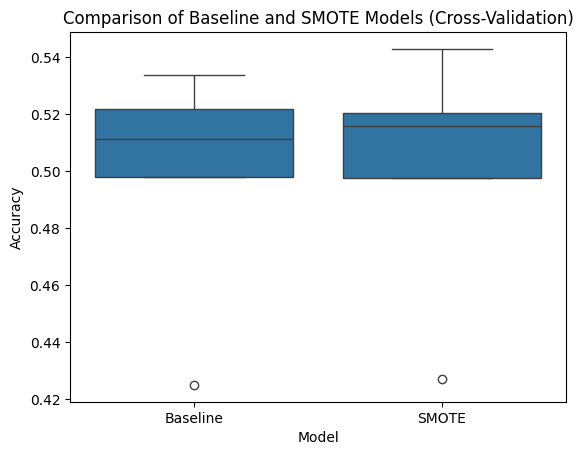

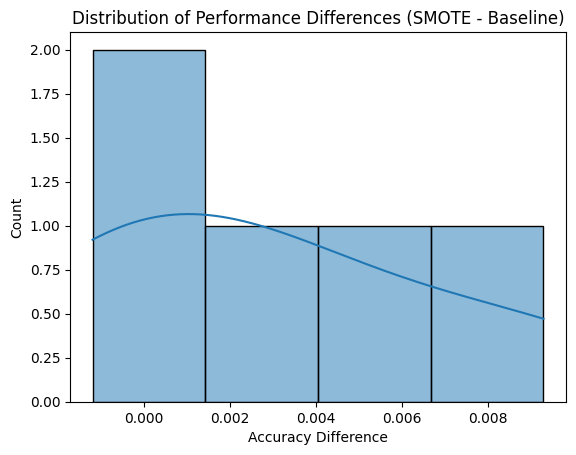

In [ ]:
# 1. Train and Evaluate Model
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

baseline_scores = cross_val_score(baseline_model, X, y, cv=5, scoring='accuracy')
smote_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

# 2. Calculate Differences
diff_scores = smote_scores - baseline_scores

# 3. Paired t-test
t_statistic, p_value_t = ttest_rel(baseline_scores, smote_scores)
print(f"Paired t-test: t-statistic = {t_statistic:.3f}, p-value = {p_value_t:.3f}")

# Visualization: Box Plot of Cross-Validation Scores
scores_df = pd.DataFrame({'Model': ['Baseline'] * len(baseline_scores) + ['SMOTE'] * len(smote_scores),
                            'Accuracy': baseline_scores.tolist() + smote_scores.tolist()})
sns.boxplot(x='Model', y='Accuracy', data=scores_df)
plt.title('Comparison of Baseline and SMOTE Models (Cross-Validation)')
plt.show()

# Visualization: Distribution of Performance Differences
sns.histplot(diff_scores, kde=True)  # Or sns.kdeplot(diff_scores)
plt.title('Distribution of Performance Differences (SMOTE - Baseline)')
plt.xlabel('Accuracy Difference')
plt.show()

The comparison of the baseline model and the SMOTE-enhanced model across five cross-validation folds shows similar distributions in accuracy, with both models achieving comparable median performance and exhibiting overlapping interquartile ranges. While the histogram of performance differences suggests that the SMOTE model generally performs slightly better, the paired t-test result (t = -1.509, p = 0.206) indicates that this improvement is not statistically significant. Therefore, we conclude that the effect of SMOTE on model accuracy was inconclusive.

Moving forward, improvements could include using more sophisticated resampling techniques, such as custom loss functions that penalize misclassification of rare genres or ensemble methods that blend oversampled and original data representations for more robust learning.



####4.1.2 Comparing Random Forest vs. XGBoost Models

Following the baseline analysis, we want to determine if there is a statistically significant difference in performance between two models (e.g., Random Forest vs. XGBoost).

H0: There is no difference in performance between the two models.

H1: There is a difference in performance between the two models.

In [ ]:
from scipy.stats import ttest_rel

# 1. Obtain Performance Scores (using cross-validation)
rf_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')
xgb_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# 2. Calculate Differences
diff_scores = rf_scores - xgb_scores

# 3. Paired t-test
t_statistic, p_value_t = ttest_rel(rf_scores, xgb_scores)
print(f"Paired t-test: t-statistic = {t_statistic:.3f}, p-value = {p_value_t:.3f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:41:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:41:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:41:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:42:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[02:42:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Paired t-test: t-statistic = 5.135, p-value = 0.007


Since the p-value is less than the typical significance level of 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in performance between the Random Forest and XGBoost models.

The Random Forest model achieved an overall weighted accuracy of 0.59, while the XGBoost model had an accuracy of 0.57. This may be attributed to the RF model being better at effectively capturing non-linear relationships and feature interactions present in the audio features.

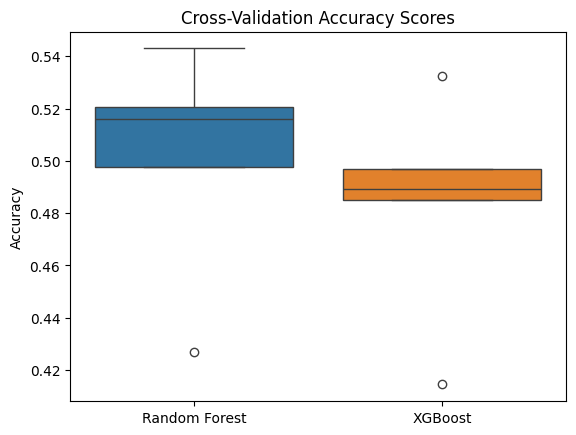

In [ ]:
scores_df = pd.DataFrame({
    'Random Forest': rf_scores,
    'XGBoost': xgb_scores
})

sns.boxplot(data=scores_df)
plt.title('Cross-Validation Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

The boxplot comparison of cross-validation accuracies similarly reveals that Random Forest slightly outperforms XGBoost in terms of median accuracy, though its results show greater variability across folds.

## Part 5. Conclusion

Key Takeaways

*   Genre classification using audio features was moderately successful, but limited by genre overlap and ambiguous feature boundaries (classification from audio features alone is a non-trivial task due to genre subjectivity and feature ambiguity)

* The project underscored the importance of thoughtful data preprocessing (e.g., genre grouping, scaling, and resampling) in building reliable ML pipelines.


Significant performnance challenges came from genre overlap, where many genres (e.g., Pop and EDM) had overlapping feature distributions, making accurate classification difficult. Another key challenge was class imbalance, where genres like Pop were overrepresented, while others like R&B and Latin were minority classes. SMOTE was applied to oversample the minority genres and improve performance.





Future iterations would benefit from integrating richer musical context (e.g., lyrics, instrumentation, listener behavior) to improve genre separability and real-world relevance, and involve:

* Incorporating spectrograms, lyrics, or user-level metadata

* Using ensemble neural architectures

* Exploring multi-label or hierarchical genre classification

This project really helped us deepen our understanding of ML pipelines, evaluation metrics, and the importance of thoughtful data preprocessing, especially in real-world applications such as song genre analysis! We had a lot of fun exploring the different skills we learned this semester with this project. Thank you to our Project TA, Kyle Liao, and CIS 5450!